In [1]:
import numpy as np
import sympy as sp
import pyLBM

%matplotlib notebook

# The vectorial schemes for hyperbolic problems

$$
\newcommand{\R}{{\mathbb R}}
\newcommand{\DdQq}[2]{{\mathrm D}_{#1}{\mathrm Q}_{#2}}
\newcommand{\drondt}{\partial_t}
\newcommand{\drondx}{\partial_x}
\newcommand{\drondy}{\partial_y}
\newcommand{\drondtt}{\partial_{tt}}
\newcommand{\drondxx}{\partial_{xx}}
\newcommand{\dx}{\Delta x}
\newcommand{\dt}{\Delta t}
\newcommand{\grandO}{{\mathcal O}}
\newcommand{\density}[2]{\,f_{#1}^{#2}}
\newcommand{\fk}[1]{\density{#1}{\vphantom{\star}}}
\newcommand{\fks}[1]{\density{#1}{\star}}
\newcommand{\moment}[2]{\,m_{#1}^{#2}}
\newcommand{\mk}[1]{\moment{#1}{\vphantom{\star}}}
\newcommand{\mke}[1]{\moment{#1}{e}}
\newcommand{\mks}[1]{\moment{#1}{\star}}
$$

Consider the conservative hyperbolic problem
$$\drondt u(t,x) + \drondx {\cdot} f(u(t,x)) = 0, \qquad t>0, \quad x\in\R^d,$$
where $u(t,x)\in\R^N$.

A vectorial scheme can be build by coupling $N$ elementary Boltzmann schemes, one for each scalar equation. The coupling takes place in the relaxation phase and in particular in the equilibrium values of the non conserved moments.

In this work session, we investigate some classical hyperbolic systems like the shallow water and the Euler systems. 

## Shallow water in 1D

The system reads
$$\begin{aligned}&\drondt h + \drondx q = 0, \\ &\drondt q + \drondx(q^2/h+gh^2/2) = 0, \end {aligned}$$
where $g$ can be taken to $1$.
The simulation will be done on $(0,1)$ and Neumann boundary conditions will be added.

We use here two coupled $\DdQq{1}{2}$ for the simulation of this problem. The velocity of the scheme will be taken to $2$.

We now write a function to initialize the Riemann problem:
$$h(0,x) = \left\{ \begin{aligned} h_L &&\text{if } 0\leq x<1/2,\\ h_R &&\text{if } 1/2<x\leq 1,  \end{aligned}\right. \qquad q(0,x) = \left\{ \begin{aligned} q_L &&\text{if } 0\leq x<1/2,\\ q_R &&\text{if } 1/2<x\leq 1,  \end{aligned}\right.$$
with $h_L=1$, $h_R=1/4$, $q_L=q_R=1/10$.

In [2]:
xmin, xmax = 0., 1.  # bounds of the domain
h_L, h_R, q_L, q_R = 1., .25, 0.10, 0.10

def Riemann_pb(x, ug, ud):
    xm = 0.5*(xmin+xmax)
    return ug*(x<xm) + ud*(x>xm) + 0.5*(ug+ud)*(x==xm)

In [19]:
h, q, X, LA, g = sp.symbols('h, q, X, LA, g')
la = 3.              # velocity of the scheme
s_h, s_q = 1.7, 1.7  # relaxation parameter

dx = 1./2048         # spatial step
s_h, s_q = 1.7, 1.5  # relaxation parameter
Tf = 0.25            # final time

dico = {
    'box':{'x':[xmin, xmax], 'label':0},
    'space_step':dx,
    'scheme_velocity':la,
    'schemes':[
        {
            'velocities':[1,2],
            'conserved_moments':h,
            'polynomials':[1, X],
            'relaxation_parameters':[0, s_h],
            'equilibrium':[h, q],
            'init':{h:(Riemann_pb, (h_L, h_R))},
        },
        {
            'velocities':[1,2],
            'conserved_moments':q,
            'polynomials':[1, X],
            'relaxation_parameters':[0, s_q],
            'equilibrium':[q, q**2/h+.5*g*h**2],
            'init':{q:(Riemann_pb, (q_L, q_R))},
        },
    ],
    'boundary_conditions':{
        0:{'method':{0: pyLBM.bc.Neumann, 1: pyLBM.bc.Neumann}, 'value':None},
    },
    'parameters':{LA:la, g:1.},
    'generator': 'numpy',
}

scheme = pyLBM.Scheme(dico)
print(scheme)

Scheme informations
	 spatial dimension: dim=1
	 number of schemes: nscheme=2
	 number of velocities:
    Stencil.nv[0]=2
    Stencil.nv[1]=2
	 velocities value:
    v[0] = (1: 1), (2: -1), 
    v[1] = (1: 1), (2: -1), 
	 polynomials:
    P[0] = 1, X, 
    P[1] = 1, X, 
	 equilibria:
    EQ[0] = h, q, 
    EQ[1] = q, 0.5*g*h**2 + q**2/h, 
	 relaxation parameters:
    s[0] = 0, 1.70000000000000, 
    s[1] = 0, 1.50000000000000, 
	 moments matrices
M      = Matrix([[1, 1, 0, 0], [0, 0, 1, 1], [3.00000000000000, -3.00000000000000, 0, 0], [0, 0, 3.00000000000000, -3.00000000000000]])
M^(-1) = Matrix([[0.500000000000000, 0, 0.166666666666667, 0], [0.500000000000000, 0, -0.166666666666667, 0], [0, 0.500000000000000, 0, 0.166666666666667], [0, 0.500000000000000, 0, -0.166666666666667]])



We compute the solution of the shallow water system with the previous scheme at $t=0.25$.

<IPython.core.display.Javascript object>


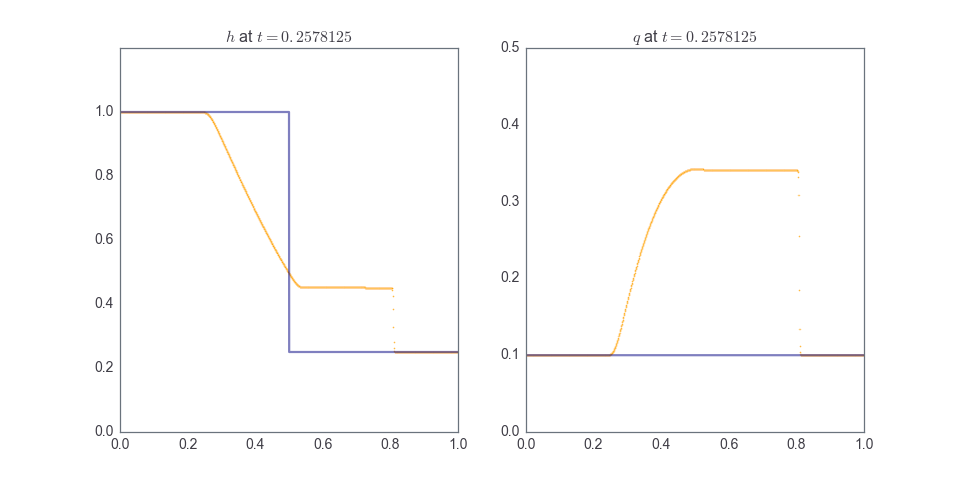

In [22]:
sol = pyLBM.Simulation(dico)
x = sol.domain.x

viewer = pyLBM.viewer.matplotlibViewer
fig = viewer.Fig(1, 2, figsize = (12,6))
ax_h = fig[0]
ax_q = fig[1]
ax_h.grid(visible = False)
ax_q.grid(visible = False)
ax_h.axis(xmin, xmax, 0, 1.2)
ax_q.axis(xmin, xmax, 0, .5)
ax_h.title = r'$h$ at $t={0:10.7f}$'.format(sol.t)
ax_q.title = r'$q$ at $t={0:10.7f}$'.format(sol.t)
ax_h.plot(x, sol.m[h], color='navy', width=2, alpha=0.5)
ax_q.plot(x, sol.m[q], color='navy', width=2, alpha=0.5)
lh = ax_h.markers(np.c_[x, sol.m[h]], color='orange', size=2, alpha=.5)
lq = ax_q.markers(np.c_[x, sol.m[q]], color='orange', size=2, alpha=.5)

def update(iframe):
    nrep = 16
    for i in range(nrep):
        sol.one_time_step()
    lh.set_offsets(np.c_[x, sol.m[h]])
    lq.set_offsets(np.c_[x, sol.m[q]])
    ax_h.title = r'$h$ at $t={0:10.7f}$'.format(sol.t)
    ax_q.title = r'$q$ at $t={0:10.7f}$'.format(sol.t)

# run the simulation
fig.animate(update, interval=100)
fig.show()

## Shallow water in 2D

The system reads
$$\begin{aligned}&\drondt h + \drondx q_x + \drondy q_y = 0, \\ &\drondt q_x + \drondx(q_x^2/h+gh^2/2) + \drondy (q_xq_h/h) = 0, \\ &\drondt q_y + \drondx (q_xq_h/h) + \drondy(q_y^2/h+gh^2/2) = 0, \end {aligned}$$
where $g$ can be taken to $1$.
The simulation will be done on $(-1,1)\times(-1,1)$ and periodical boundary conditions will be added.

We propose a vectorial scheme build with $3$ elementary $\DdQq{2}{4}$ schemes, one for each scalar equation. The velocity of the scheme will be taken to $4$.

The initialization reads
$$h(x, y) = 1 + {\mathbf 1}_{x^2+y^2<r^2},\qquad q_x=q_y = 0,$$
where $r=1/4$.

In [5]:
import numpy as np
import sympy as sp
import pyLBM

%matplotlib notebook

In [6]:
X, Y, LA = sp.symbols('X, Y, LA')
h, qx, qy = sp.symbols('h, qx, qy')

def h0(x, y):
    return h_l * np.ones((x.size, y.size), dtype='float64') \
        + (h_h-h_l) * ((x-0.5*(xmin+xmax))**2+(y-0.5*(ymin+ymax))**2 < 0.25**2)

# parameters
dx = 1./128  # spatial step
la = 4.      # velocity of the scheme
h_l = 1.     # low value of the water height
h_h = 2.     # high value of the water height
L = 2        # size of the domain
g = 1.       # gravity
s_h1 = 2.
s_h2 = 1.5
s_q1 = 1.5
s_q2 = 1.2
# initialization
xmin, xmax, ymin, ymax = -.5*L, .5*L, -.5*L, .5*L
s_h = [0., s_h1, s_h1, s_h2]
s_q = [0., s_q1, s_q1, s_q2]

vitesse = list(range(1,5))
polynomes = [1, X, Y, X**2-Y**2]

dico = {
    'box': {
        'x': [xmin, xmax], 
        'y': [ymin, ymax], 
        'label':-1,
    },
    'space_step': dx,
    'scheme_velocity': la,
    'parameters': {LA: la},
    'schemes':[
        {
            'velocities': vitesse,
            'conserved_moments': h,
            'polynomials': polynomes,
            'relaxation_parameters': s_h,
            'equilibrium': [h, qx, qy, 0.],
            'init': {h: (h0,)},
        },
        {
            'velocities': vitesse,
            'conserved_moments': qx,
            'polynomials': polynomes,
            'relaxation_parameters': s_q,
            'equilibrium': [qx, qx**2/h + 0.5*g*h**2, qx*qy/h, 0.],
            'init': {qx: 0.},
        },
        {
            'velocities': vitesse,
            'conserved_moments': qy,
            'polynomials': polynomes,
            'relaxation_parameters': s_q,
            'equilibrium': [qy, qx*qy/h, qy**2/h + 0.5*g*h**2, 0.],
            'init': {qy: 0.},
        },
    ],
    'generator': 'cython',
}

sol = pyLBM.Simulation(dico)

<IPython.core.display.Javascript object>


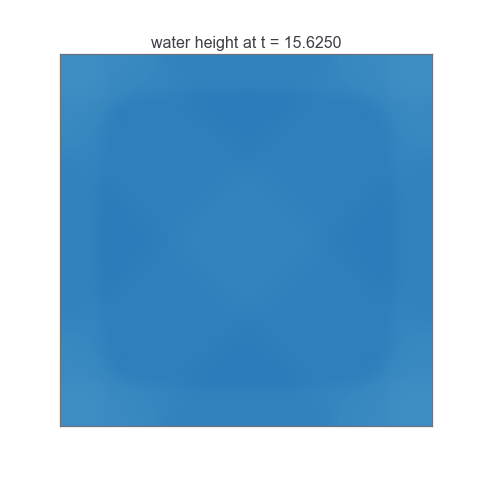

In [8]:
viewer = pyLBM.viewer.matplotlibViewer
fig = viewer.Fig(figsize = (6,6))
ax = fig[0]
ax.grid(visible = False)
ax.xaxis_set_visible(False)
ax.yaxis_set_visible(False)
image = ax.image(sol.m[h].T, cmap='Blues', clim=[-1., 2.])

def update(iframe):
    nrep = 16
    for i in range(nrep):
        sol.one_time_step()
    image.set_data(sol.m[h].T)
    ax.title = 'water height at t = {0:7.4f}'.format(sol.t)

# run the simulation
fig.animate(update, interval=10)
fig.show()